       vidid  adview    views likes dislikes comment   published duration  \
0  VID_18655      40  1031602  8523      363    1095  14-09-2016  PT7M37S   
1  VID_14135       2     1707    56        2       6  01-10-2016  PT9M30S   
2   VID_2187       1     2023    25        0       2  02-07-2016  PT2M16S   
3  VID_23096       6   620860   777      161     153  27-07-2016  PT4M22S   
4  VID_10175       1      666     1        0       0  29-06-2016    PT31S   

  category  
0        F  
1        D  
2        C  
3        H  
4        D  
(14999, 9)


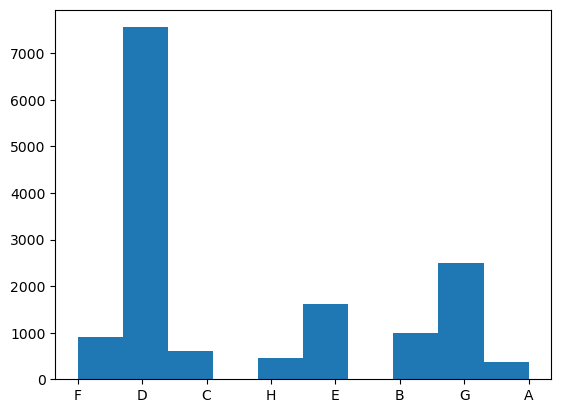

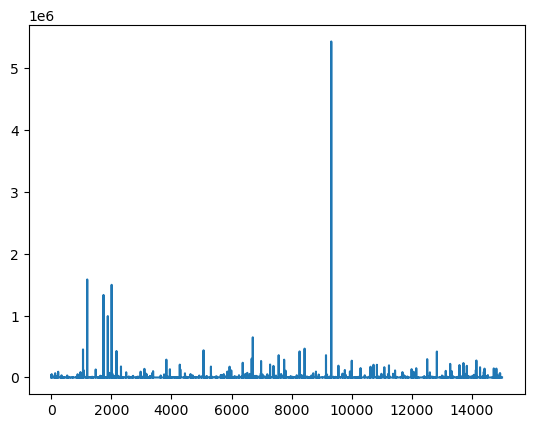

ValueError: could not convert string to float: 'VID_18655'

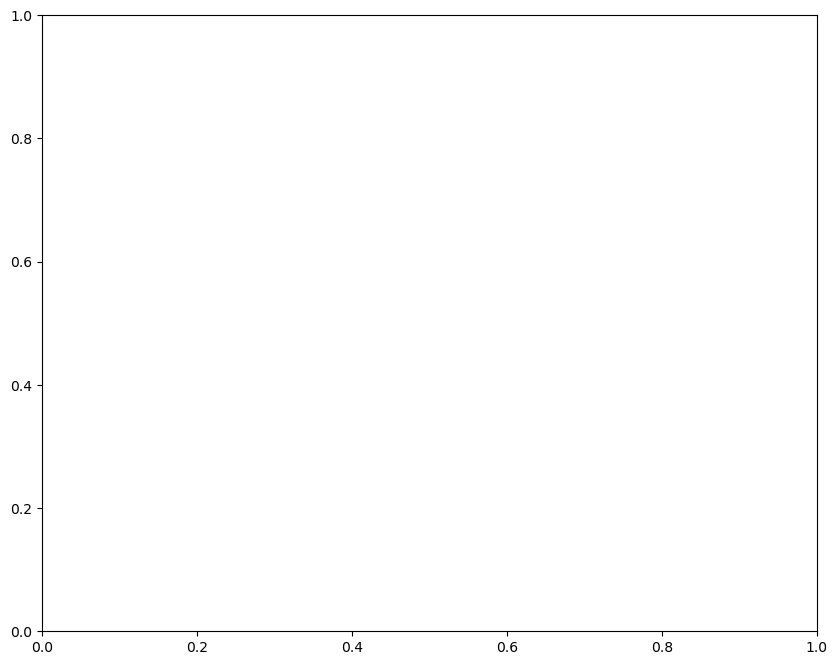

In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data
path = "C:\\Users\\nidhi\\OneDrive\\Documents\\"
data_train = pd.read_csv(path + "train.csv")

# Checking the shape of the dataset
print(data_train.head())
print(data_train.shape)

# Data visualization
plt.hist(data_train["category"])
plt.show()

plt.plot(data_train["adview"])
plt.show()

# Heatmap
f, ax = plt.subplots(figsize=(10, 8))
corr = data_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

# Cleaning the dataset by removing 'F' values
data_train = data_train[data_train.views != 'F']
data_train = data_train[data_train.likes != 'F']
data_train = data_train[data_train.dislikes != 'F']
data_train = data_train[data_train.comment != 'F']

# Assigning each category a number for Category feature
category = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
data_train["category"] = data_train["category"].map(category)

# Converting features to numeric
data_train["views"] = pd.to_numeric(data_train["views"])
data_train["comment"] = pd.to_numeric(data_train["comment"])
data_train["likes"] = pd.to_numeric(data_train["likes"])
data_train["dislikes"] = pd.to_numeric(data_train["dislikes"])
data_train["adview"] = pd.to_numeric(data_train["adview"])

# Converting duration from PT#H#M#S to seconds
import re

def convert_duration(duration):
    match = re.match(r'PT(\d+H)?(\d+M)?(\d+S)?', duration)
    hours = int(match.group(1)[:-1]) if match.group(1) else 0
    minutes = int(match.group(2)[:-1]) if match.group(2) else 0
    seconds = int(match.group(3)[:-1]) if match.group(3) else 0
    return hours * 3600 + minutes * 60 + seconds

data_train['duration'] = data_train['duration'].apply(convert_duration)

# Converting 'published' to datetime and then encoding
data_train['published'] = pd.to_datetime(data_train['published'], format='%d-%m-%Y')
data_train['published'] = data_train['published'].map(lambda x: x.toordinal())

# Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train[['views', 'likes', 'dislikes', 'comment', 'duration', 'published']] = scaler.fit_transform(data_train[['views', 'likes', 'dislikes', 'comment', 'duration', 'published']])

# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X = data_train.drop(['adview', 'vidid'], axis=1)
y = data_train['adview']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training and evaluating models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_mse, lr_r2 = evaluate_model(lr, X_test, y_test)

# Support Vector Regressor
svr = SVR()
svr.fit(X_train, y_train)
svr_mse, svr_r2 = evaluate_model(svr, X_test, y_test)

# Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_mse, dt_r2 = evaluate_model(dt, X_test, y_test)

# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_mse, rf_r2 = evaluate_model(rf, X_test, y_test)

# Output the evaluation results
print(f"Linear Regression: MSE = {lr_mse}, R2 = {lr_r2}")
print(f"Support Vector Regressor: MSE = {svr_mse}, R2 = {svr_r2}")
print(f"Decision Tree Regressor: MSE = {dt_mse}, R2 = {dt_r2}")
print(f"Random Forest Regressor: MSE = {rf_mse}, R2 = {rf_r2}")

# Continue to build and train a neural network using Keras
from keras.models import Sequential
from keras.layers import Dense

# Build the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

# Evaluate the model
nn_mse, nn_r2 = evaluate_model(model, X_test, y_test)

# Output the evaluation results for the neural network
print(f"Neural Network: MSE = {nn_mse}, R2 = {nn_r2}")

# Save the best model based on error as well as generalization
import joblib

best_model = rf  # Assuming RandomForest is the best based on your evaluation
joblib.dump(best_model, 'best_model.pkl')

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
